In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gwatpy.mcmc_routines as gmcmc
from corner import corner
import h5py 


Set parameters to pick out dataset

In [2]:
beta = 2
M = 3
sigma = 1
t = 100
dt =1
run_id = "{}_{}_{}_{}_{}".format(beta,M,sigma,t,dt)
dirname = "../data/transdimensionalChebyshev/{}/".format(run_id)

Routines for unpacking 

In [3]:
def RJPTMCMC_unpack_file(filename):
    f = h5py.File(filename,'r')
    chains = list(f["MCMC_OUTPUT"].keys())
    chains_N = len(chains)
    data = f["MCMC_OUTPUT"][chains[0]]
    status = f["MCMC_OUTPUT/STATUS"][chains[0]]
    for x in range(chains_N-1):
        if( "CHAIN" in chains[x+1]):
            data = np.insert(data,-1, f["MCMC_OUTPUT"][chains[x+1]],axis=0)
            status = np.insert(status,-1, f["MCMC_OUTPUT/STATUS"][chains[x+1]],axis=0)
    model_status = []
    if "MCMC_OUTPUT/MODEL_STATUS" in f.keys():
        model_status = f["MCMC_OUTPUT/MODEL_STATUS"][chains[0]]
        for x in range(chains_N-1):
            if( "CHAIN" in chains[x+1]):
                model_status = np.insert(model_status,-1, f["MCMC_OUTPUT/MODEL_STATUS"][chains[x+1]],axis=0)
    return data, status,model_status

True data 

In [4]:
N = 100
time = np.linspace(0,N,N)
dn = 2/ (N-1)
sigma = 1
beta = 5

True data: created from a polynomial of order M and beta and noise sigma: 
$$ y(t) =  \sum_i^M \alpha_i (t/T)^i + \mathcal{N}(0,\sigma^2)$$
with $ T $ being the length of the signal
$$
\alpha \sim \mathcal{N} (0,\beta^2)
$$


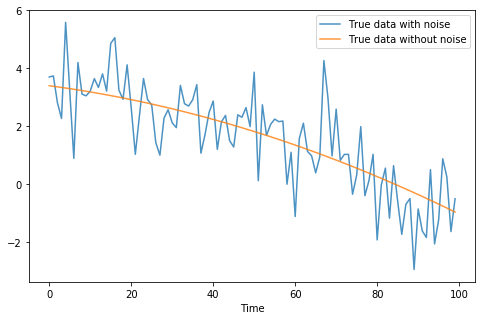

In [5]:
true_data = np.loadtxt(dirname+"full_data_transdimensional.csv")
true_clean_data = np.loadtxt(dirname+"clean_data_transdimensional.csv")
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(true_data,label='True data with noise',alpha=.8)
ax.plot(true_clean_data,label='True data without noise',alpha=.8)
ax.set_xlabel("Time")
plt.legend()
plt.savefig("../plots/transdimensional_true_data.jpg")
plt.show()
plt.close()

In [6]:
labels = [r'$\sigma$']
for x in np.arange(10):
    labels.append('p_{}'.format(x+1))

Recovery model is Chebyshev polynomial with order P, assuming gaussian noise and fitting for $ \sigma $ of the noise. This means the model dimension is P+1
$$
y'(t) = \sum_i^P p_i \cos\left( i \times \arccos( x)\right)
$$
where $ x $ is 
$$
x = -1 + 2 t/T
$$

The likelihood is chi squared (with $N = T/dt$):
$$
\ln \mathcal{L} = - \sum_i^{N} \left( y (t_i) -  y' (t_i)\right)^2 / (2 \sigma^2 ) - (N/2)\log\left( 2 \pi \sigma^2\right) 
$$

The prior for the model is a simple flat prior for each parameter

$$
p(\sigma) \sim U(0.01,10)
$$

for the noise standard deviation, and

$$
p(p_i) \sim U(-10,10)
$$

In [7]:
def cheb_fn(P,coeff,x ):
    return np.sum(coeff[:P] * np.cos(np.arange(P)*np.arccos(x)))

Import the RJPTMCMC data and unpack 

In [8]:
dataDir = ""
# dataDir = "equalModelWeight/"
# dataDir = "unadjustedModelWeight/"
print("Reading in file: ",dirname+"{}transdimensionalChebyshev_output.hdf5".format(dataDir))
datafile = h5py.File(dirname+"{}transdimensionalChebyshev_output.hdf5".format(dataDir))
data, status, model_status = RJPTMCMC_unpack_file(dirname+"{}transdimensionalChebyshev_output.hdf5".format(dataDir))
data = [data,status]
datafilePrior = h5py.File(dirname+"{}transdimensionalChebyshevPrior_output.hdf5".format(dataDir))
dataPrior, statusPrior, model_statusPrior = RJPTMCMC_unpack_file(dirname+"{}transdimensionalChebyshevPrior_output.hdf5".format(dataDir))
dataPrior = [dataPrior,statusPrior]


Reading in file:  ../data/transdimensionalChebyshev/2_3_1_100_1/transdimensionalChebyshev_output.hdf5


Check some basic plots -- plot trace/histogram of one dimension at a time 

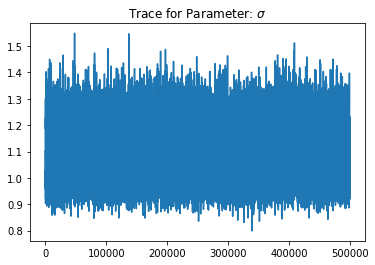

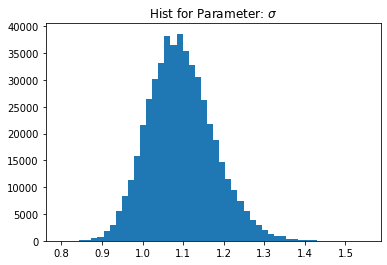

In [9]:
ID = 0

plt.plot(data[0][np.array(data[1][:,ID],dtype=bool),ID])
plt.title("Trace for Parameter: {}".format(labels[ID]))
plt.show()
plt.close()
plt.hist(data[0][np.array(data[1][:,ID],dtype=bool),ID],bins=50)
plt.title("Hist for Parameter: {}".format(labels[ID]))
plt.show()
plt.close()

Plot Histograms of the dimensions -- probability of different models 

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5]
Probabilities:
Dim: 1 Probability: 0.000e+00
Dim: 2 Probability: 0.000e+00
Dim: 3 Probability: 6.957e-01
Dim: 4 Probability: 2.969e-01
Dim: 5 Probability: 7.254e-03
Dim: 6 Probability: 2.020e-04
Dim: 7 Probability: 1.000e-05
Dim: 8 Probability: 0.000e+00
Dim: 9 Probability: 0.000e+00
Dim: 10 Probability: 0.000e+00


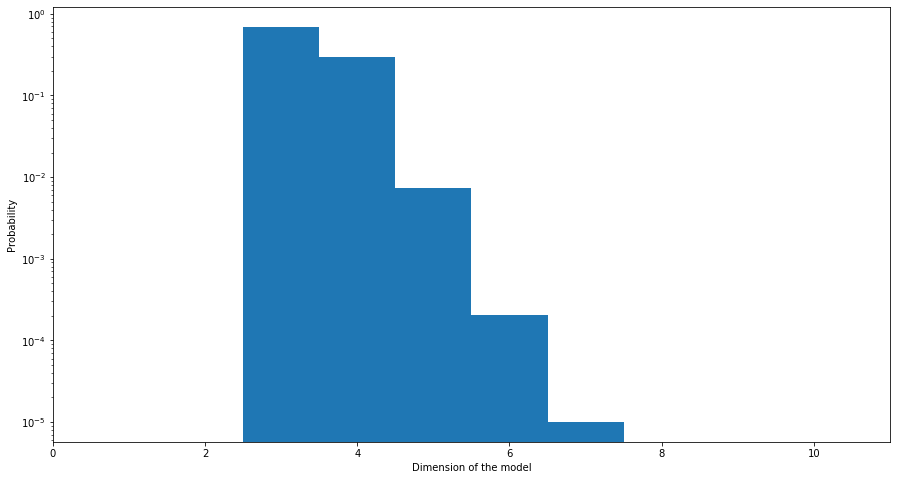

In [10]:
bins = np.linspace(0.5,len(data[1][0])+.5,len(data[1][0])+1)
mids = bins[1:] - .5
print(bins)
#Collapse dimensions structure to the sum of the active dimensions (N samples, maxDim) => (N samples)
dims = np.sum(data[1],axis=1)

fig, ax = plt.subplots(figsize=[15,8])
probs, bins, _patches = ax.hist(dims,bins=bins,log=True,density=True)
print("Probabilities:")
[print("Dim: {}".format(x+1),"Probability: {:.3e}".format( probs[x])) for x in np.arange(len(probs))]
ax.set_xlabel("Dimension of the model")
ax.set_ylabel("Probability")
plt.savefig("../plots/posterior_modelspace.jpg")
plt.savefig("../plots/posterior_modelspace.pdf")
plt.show()
plt.close()


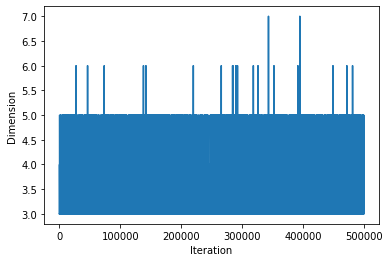

In [11]:
plt.plot(dims)
plt.xlabel("Iteration")
plt.ylabel("Dimension")
plt.show()
plt.close()

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5]
499995
| Dim | Probability | Scaling relative to 2 dimensions(Emperical) | Scaling (expected)
| --- | --- | --- | --- |
|2 | 1.098e-01 |  1.000e+00 |  1.000e+00 |
|3 | 1.102e-01 |  1.003e+00 |  5.000e-02 |
|4 | 1.099e-01 |  1.001e+00 |  2.500e-03 |
|5 | 1.106e-01 |  1.008e+00 |  1.250e-04 |
|6 | 1.121e-01 |  1.021e+00 |  6.250e-06 |
|7 | 1.128e-01 |  1.028e+00 |  3.125e-07 |
|8 | 1.118e-01 |  1.018e+00 |  1.563e-08 |
|9 | 1.118e-01 |  1.018e+00 |  7.813e-10 |
|10 | 1.110e-01 |  1.011e+00 |  3.906e-11 |


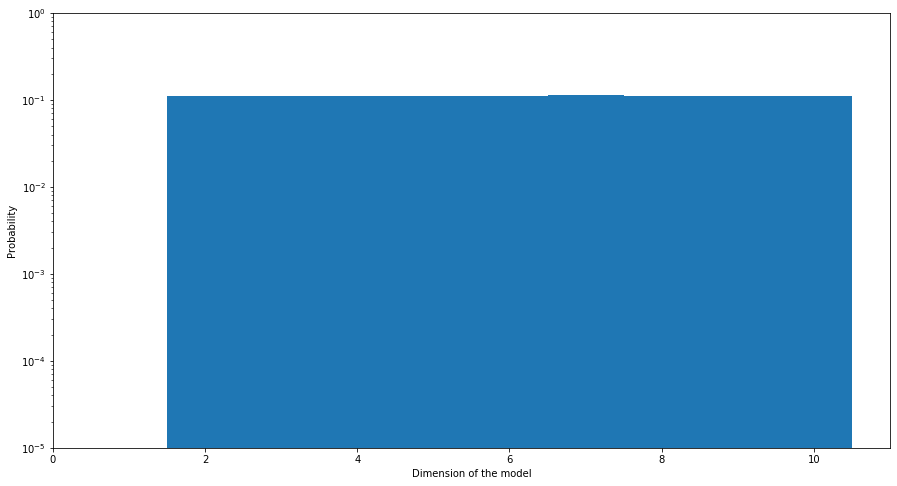

In [12]:
bins = np.linspace(0.5,len(data[1][0])+.5,len(data[1][0])+1)
mids = bins[1:] - .5
print(bins)
dims = np.sum(dataPrior[1],axis=1)
print(len(dims))
fig, ax = plt.subplots(figsize=[15,8])
probs, bins, _patches = ax.hist(dims,bins=bins,log=True,density=True)
print("| Dim | Probability | Scaling relative to 2 dimensions(Emperical) | Scaling (expected)")
print("| --- | --- | --- | --- |")
[print("|{}".format(x+2),"{:.3e}".format( probs[x+1])," {:.3e}".format( probs[x+1]/probs[1])," {:.3e} |".format((1./20.)**x),sep=' | ') for x in np.arange(len(probs)-1)]
# [print("| Dim: {}".format(x+2),"Probability: {:.3e}".format( probs[x+1]),"Scaling Relative to 2 Dim: {:.3e}".format( probs[x+1]/probs[1]),"Scaling expectation: {:.3e} |".format((1./20.)**x),sep=' | ') for x in np.arange(len(probs)-1)]
# [print( (1./20.)**x , cts[x+1]/cts[1], ((1./20.)**x - cts[x+1]/cts[1])/((1./20.)**x ) ) for x in np.arange(len(cts[1:])) ]

ax.set_xlabel("Dimension of the model")
ax.set_ylabel("Probability")
ax.set_ylim((10**-5,1))
plt.savefig("../plots/prior_modelspace_adjusted.jpg")
plt.savefig("../plots/prior_modelspace_adjusted.pdf")
plt.show()
plt.close()


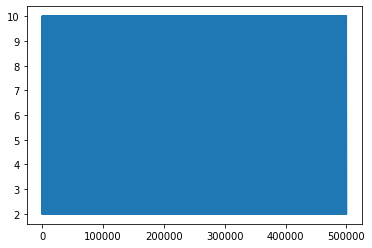

In [13]:
plt.plot(dims)

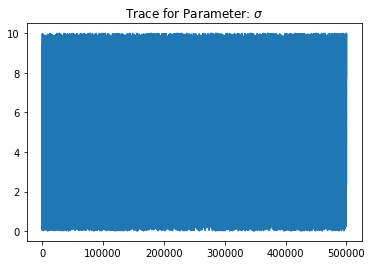

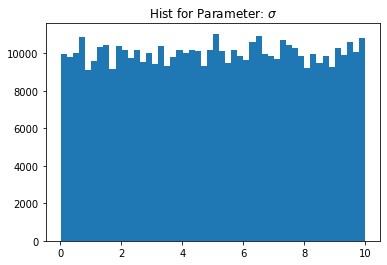

In [14]:
ID = 0

plt.plot(dataPrior[0][np.array(dataPrior[1][:,ID],dtype=bool),ID])
plt.title("Trace for Parameter: {}".format(labels[ID]))
plt.show()
plt.close()
plt.hist(dataPrior[0][np.array(dataPrior[1][:,ID],dtype=bool),ID],bins=50)
plt.title("Hist for Parameter: {}".format(labels[ID]))
plt.show()
plt.close()

Used a traditional PTMCMC with the most favored model (P=5 or 6 dimensions)

data shape:  (44955, 3)


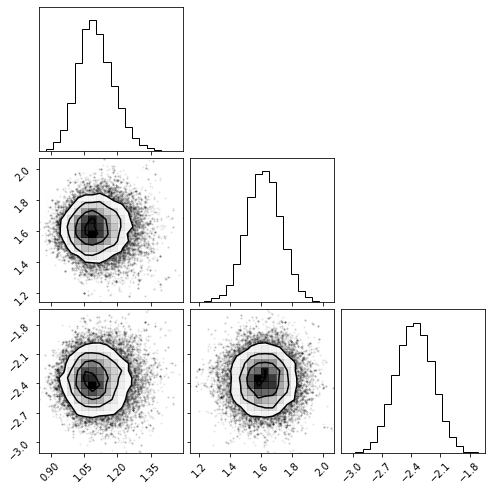

In [15]:
p = 2
dataFile = h5py.File(dirname+"transdimensionalChebyshevSingle_{}_output.hdf5".format(p),'r')
first=True
dataSingle = None
for chain in dataFile["MCMC_OUTPUT"].keys():
    if "CHAIN" in chain:
        if first:
            dataSingle = np.array(dataFile["MCMC_OUTPUT"][chain])
            first = False
        else:
            dataSingle = np.insert(dataSingle,len(dataSingle), np.array(dataFile["MCMC_OUTPUT"][chain]),axis=0)
print("data shape: ",dataSingle.shape)
fig = corner(dataSingle)
plt.show()
plt.close()


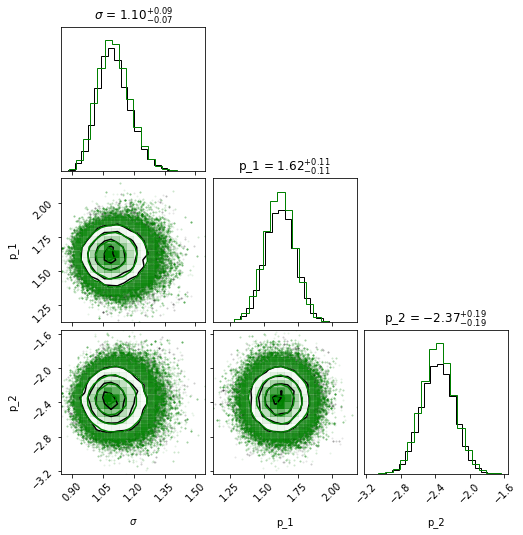

In [16]:
fig = corner(dataSingle,weights=np.ones(len(dataSingle))/len(dataSingle),labels=labels,show_titles=True)
dims = np.sum(data[1],axis=1)
dataPlot = data[0][dims==len(dataSingle[0]),:len(dataSingle[0])]
corner(dataPlot,fig=fig,weights=np.ones(len(dataPlot))/len(dataPlot),color='green')
plt.savefig("../plots/MCMC_RJMCMC_comp.jpg")
plt.savefig("../plots/MCMC_RJMCMC_comp.pdf")
plt.show()
plt.close()

In [17]:
ids = np.random.choice(np.arange(len(data[0])),size = 1000)
recon = [[cheb_fn(np.sum(data[1][x,1:]), data[0][x,1:],-1 + dn *t) for t in np.arange(len(time))] for x in ids]
reconPrior = [[cheb_fn(np.sum(dataPrior[1][x,1:]), dataPrior[0][x,1:],-1 + dn *t) for t in np.arange(len(time))] for x in np.random.choice(np.arange(len(dataPrior[0])),size = 1000)]
reconSingle = [[cheb_fn(len(dataSingle[0])-1, dataSingle[x,1:],-1 + dn *t) for t in np.arange(len(time))] for x in np.random.choice(np.arange(len(dataSingle)),size = 1000)]


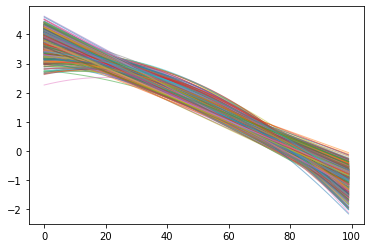

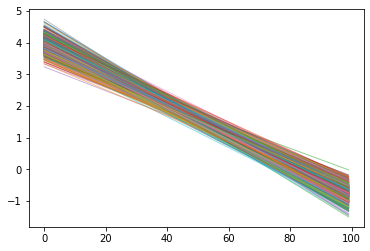

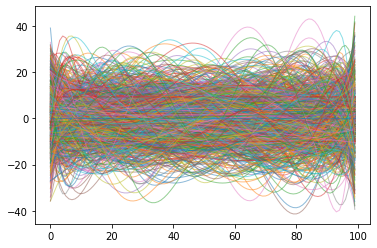

In [18]:
for x in recon:
    plt.plot(x,alpha=.5,linewidth=1)
plt.show()
plt.close()
for x in reconSingle:
    plt.plot(np.array(x),alpha=.5,linewidth=1)
plt.show()
plt.close()
for x in reconPrior:
    plt.plot(x,alpha=.5,linewidth=1)
plt.show()
plt.close()

Calculate 90% and mean signals 

In [19]:
up = np.quantile(recon,.9,axis=0)
down = np.quantile(recon,.1,axis=0)
upSingle = np.quantile(reconSingle,.9,axis=0)
downSingle = np.quantile(reconSingle,.1,axis=0)
upPrior = np.quantile(reconPrior,.9,axis=0)
downPrior = np.quantile(reconPrior,.1,axis=0)
 
mean = np.mean(recon,axis=0)
meanSingle = np.mean(reconSingle,axis=0)
meanPrior = np.mean(reconPrior,axis=0)


Plot confidence regions and residuals 

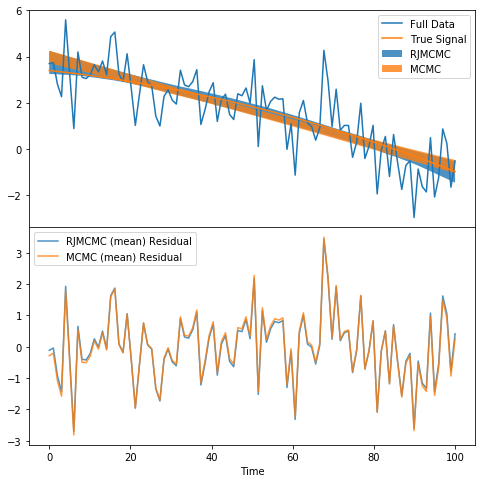

Likelihood approx for single dim:  -10223.279450627198
Likelihood approx for RJ:  -10145.576164914617


In [20]:
fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=[8,8])
ax[0].plot(time,true_data,label='Full Data')
ax[0].plot(time,true_clean_data,label="True Signal")
ax[0].fill_between(time,up,down,alpha=.8,label='RJMCMC')
ax[0].fill_between(time,upSingle,downSingle,alpha=.8,label='MCMC')
# ax.fill_between(time,upPrior,downPrior,alpha=.3,label='RJMCMC Prior')
ax[0].legend()
ax[1].plot(time,true_data-mean,alpha=.8,label='RJMCMC (mean) Residual')
ax[1].plot(time,true_data-meanSingle,alpha=.8,label='MCMC (mean) Residual')
# ax.plot(time,true_data-meanPrior,alpha=.8,label='Prior (mean) Residual')
ax[1].legend()
ax[1].set_xlabel("Time")
plt.subplots_adjust( hspace=0)
plt.savefig("../plots/reconstructions_ptrjmcmc.jpg")
plt.savefig("../plots/reconstructions_ptrjmcmc.pdf")
plt.show()
plt.close()

sigmaFit = np.mean(dataSingle[:,0])
print("Likelihood approx for single dim: ", np.sum( -(true_data-meanSingle)**2/(2.*sigmaFit*sigmaFit) - (len(time)/2) * np.log(2.*np.pi * sigmaFit*sigmaFit)) )
sigmaFit = np.mean(data[0][:,0])
print("Likelihood approx for RJ: ", np.sum( -(true_data-mean)**2/(2.*sigmaFit*sigmaFit) - (len(time)/2) * np.log(2.*np.pi * sigmaFit*sigmaFit)) )



Load in Bilby evidences 

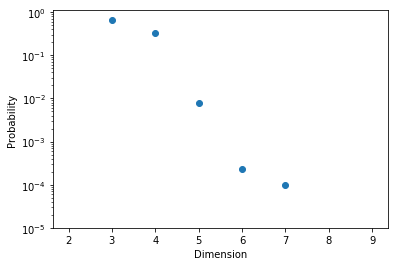

In [25]:
lnE = []
# mods = np.array([1,2,3,4,5,6,7,8,9])
mods = np.array([1,2,3,4,5,6,7,8])
for x in mods:
#     lnE.append(np.loadtxt("../data/bilby_transdimensionallog_evidence_{}.txt".format(x)))
    lne = np.loadtxt(dirname+"bilby/log_evidence_{}.txt".format(x))
    
    lnE.append(float(lne))
# print(lnE)
evidence = np.exp(np.array(lnE)) / np.sum(np.exp(np.array(lnE)))
# print(evidence)
fig, ax = plt.subplots()
ax.scatter(mods+1,evidence)
ax.set_yscale('log')
ax.set_ylim([10**-5,1.1])
ax.set_ylabel("Probability")
ax.set_xlabel("Dimension")
plt.show()
plt.close()

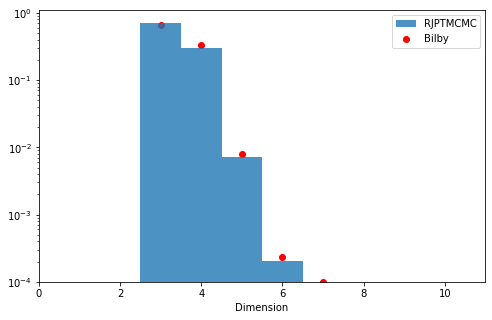

In [28]:
bins = np.linspace(0.5,len(data[1][0])+.5,len(data[1][0])+1)
mids = bins[1:] - .5
# print(bins)
dims = np.sum(data[1],axis=1)

fig, ax = plt.subplots(figsize=[8,5])
# ax.hist(dims,bins=bins,density=True,alpha=.8,label='RJPTMCMC')
ax.hist(dims,bins=bins,log=True,density=True,alpha=.8,label='RJPTMCMC')
ax.scatter(mods+1,evidence,color='red',label='Bilby')
ax.set_ylim((10**-4,1.1))
ax.set_xlabel("Dimension")
ax.legend()
plt.savefig("../plots/evidence_bilby_vs_ptrjmcmc_adjusted.jpg")
plt.savefig("../plots/evidence_bilby_vs_ptrjmcmc_adjusted.pdf")
plt.show()
plt.close()


Load in Bilby Samples 

In [31]:
dataBilby = []
for x in np.arange(8):
    dataBilby.append(np.loadtxt(dirname+"bilby/{}_samples.dat".format(x+1),skiprows=1))
    print(dataBilby[-1].shape)    

(2670, 2)
(3274, 3)
(3611, 4)
(4152, 5)
(4628, 6)
(4938, 7)
(5191, 8)
(5638, 9)


Reconstruct the signal with Bilby samples 

In [32]:
reconBilby = [[[cheb_fn(ct+1,dataBilby[ct][x,1:],-1 + dn *t) for t in np.arange(len(time))] for x in np.random.choice(np.arange(len(dataBilby[ct])),size = 1000)] for ct in np.arange(len(dataBilby))]


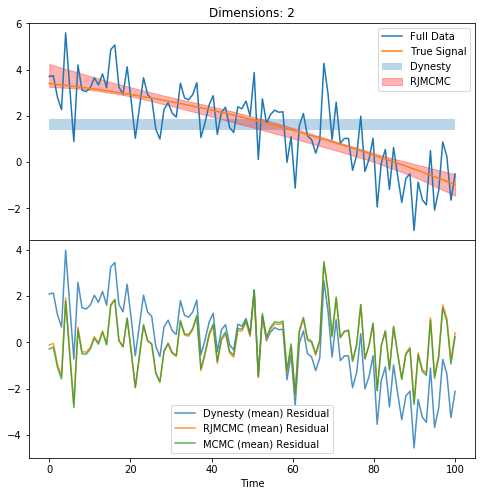

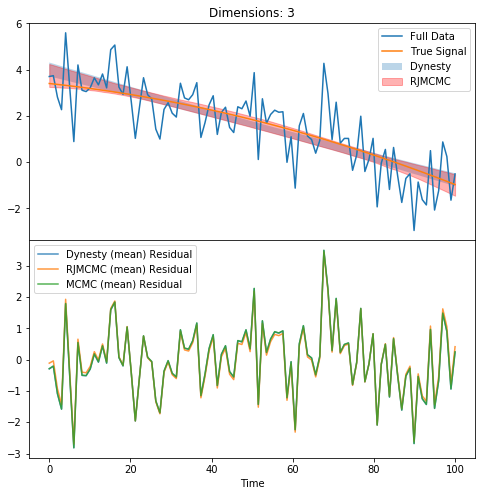

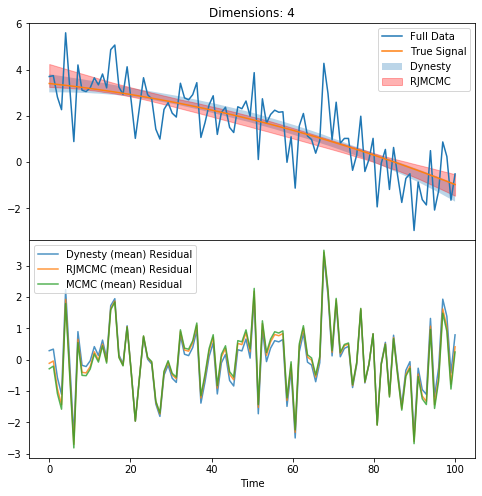

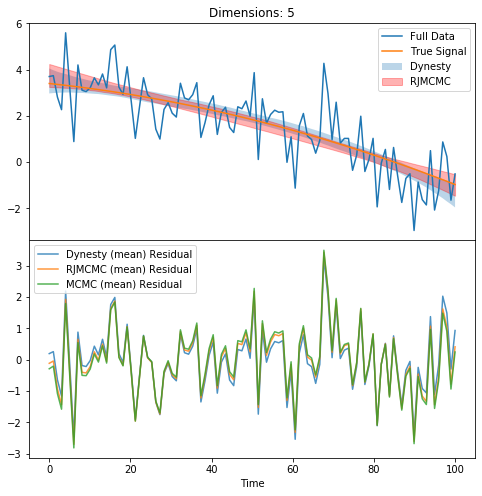

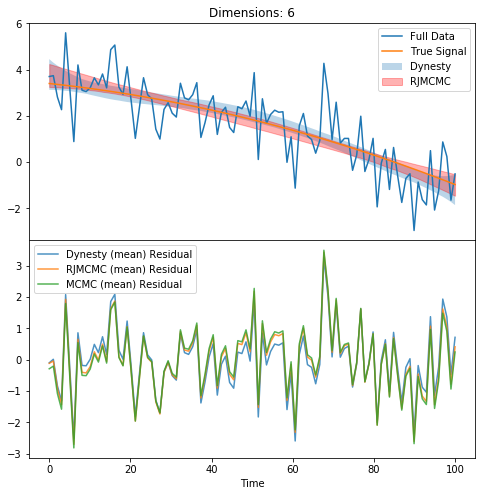

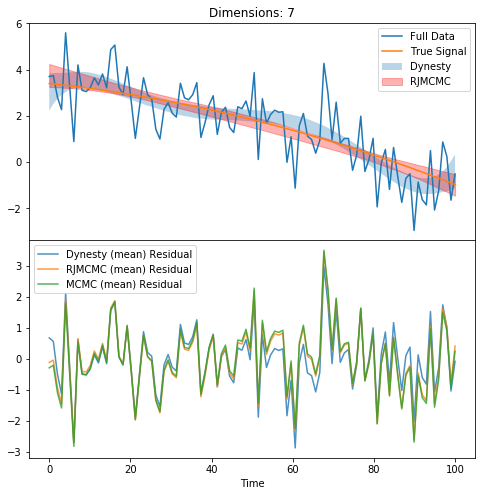

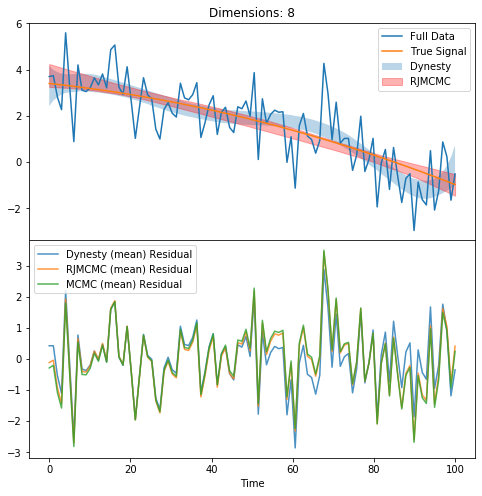

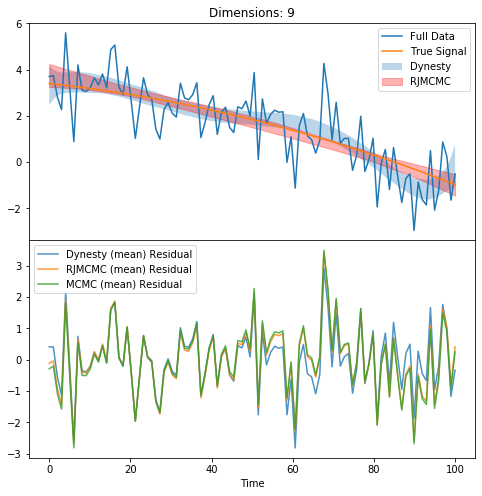

In [33]:
ct = 2
for d in reconBilby:
    fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=[8,8])
    
#     for x in d:
#         ax.plot(x,alpha=.5,linewidth=1)
    upB = np.quantile(d,.9,axis=0)
    downB = np.quantile(d,.1,axis=0)
    meanB = np.mean(d,axis=0)
    ax[0].fill_between(time,upB,downB,alpha=.3,label='Dynesty')
    ax[0].fill_between(time,up,down,alpha=.3,label='RJMCMC',color='r')

    ax[0].plot(time,true_data,label='Full Data')
    ax[0].plot(time,true_clean_data,label="True Signal")
    ax[0].set_title("Dimensions: {}".format(ct))
    ax[0].legend()
    
    ax[1].plot(time,true_data-meanB,alpha=.8,label='Dynesty (mean) Residual')
    ax[1].plot(time,true_data-mean,alpha=.8,label='RJMCMC (mean) Residual')
    ax[1].plot(time,true_data-meanSingle,alpha=.8,label='MCMC (mean) Residual')
    ax[1].legend()

    ax[1].set_xlabel("Time")
    plt.subplots_adjust( hspace=0)
    
    plt.savefig("../plots/reconstruction_bilby_{}.jpg".format(ct))
    plt.savefig("../plots/reconstruction_bilby_{}.pdf".format(ct))
    ct+=1
    plt.show()
    plt.close()

Focus on specific dimension comparisons 

(2670, 2) 0 0


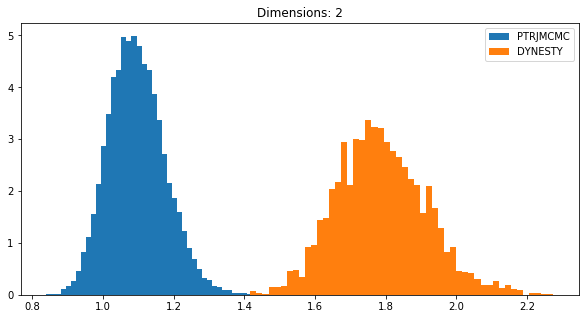

(3274, 3) 0 0


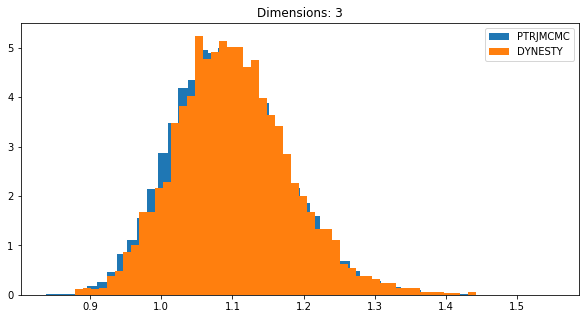

(3611, 4) 0 0


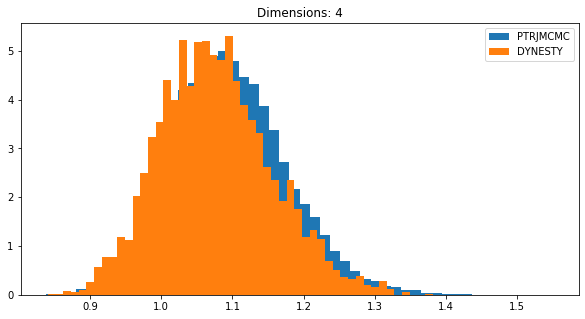

(4152, 5) 0 0


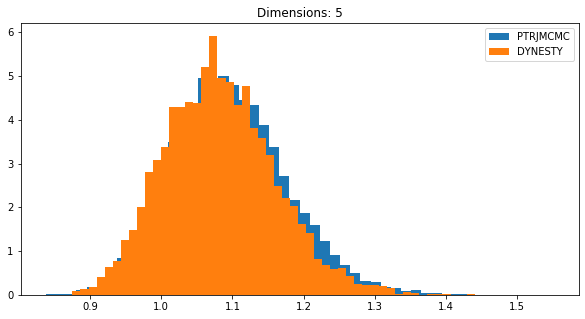

In [29]:
ct=2
ID = 0
startingData = 0
if ID == 0 or ID == 1:
    ct = 2
    startingData = 0
else:
    ct = 2 + (ID-1)
    startingData = ID -1
# for d in dataBilby[ID-1:]:
for d in dataBilby[startingData:]:
    print(d.shape,ID,startingData)
    fig,ax=plt.subplots(figsize=[10,5])
#     for x in d:
#         ax.plot(x,alpha=.5,linewidth=1)
   
    ax.hist(data[0][np.array(data[1][:,ID],dtype=bool),ID],bins=50,density=True,label='PTRJMCMC')
    ax.hist(d[:,ID],bins=50,density=True,label='DYNESTY')
    ax.set_title("Dimensions: {}".format(ct ))
    ax.legend()
    ct+=1
    plt.show()
    plt.close()

Corner comparison between Bilby 5 dimension and MCMC 5 dimension (Should be identical.. )

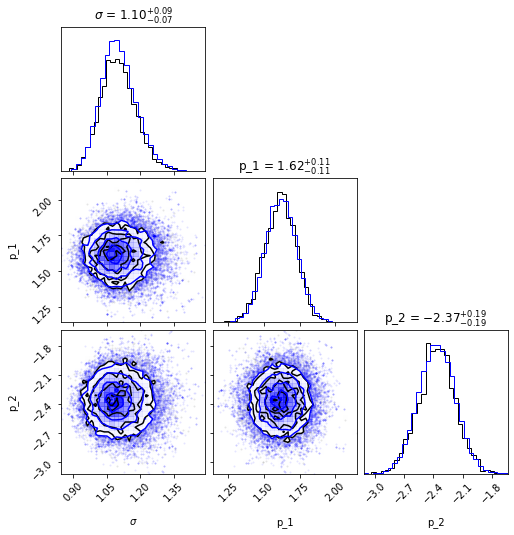

0 0.2640682872475115 0.26253074154121414 0.005839531112824192
1 0.3647216320226907 0.35842272155045474 0.017420893743032826
2 0.6254121616942285 0.6420777833466649 -0.026297047511329424


In [30]:
bilbyID = len(dataSingle[0])-2
fig = corner(dataBilby[bilbyID],bins=30,labels=labels,show_titles=True,weights=np.ones(len(dataBilby[bilbyID]))/len(dataBilby[bilbyID]) )
corner(dataSingle,fig=fig,bins=30,labels=labels,show_titles=True,color='blue',weights=np.ones(len(dataSingle))/len(dataSingle) ) 
plt.savefig("../plots/bilby_ptmcmc_comp_5dim.pdf")
plt.savefig("../plots/bilby_ptmcmc_comp_5dim.jpg")
plt.show()
plt.close()
for x in np.arange(len(dataSingle[0])):
    cP = np.quantile(dataSingle[:,x],.95)-np.quantile(dataSingle[:,x],.05)
    cB =np.quantile(dataBilby[bilbyID][:,x],.95)-np.quantile(dataBilby[bilbyID][:,x],.05)
    print(x,cP, cB, 2*(cP - cB)/(cP + cB))    
    

Comparison of RJPTMCMC and PTMCMC 

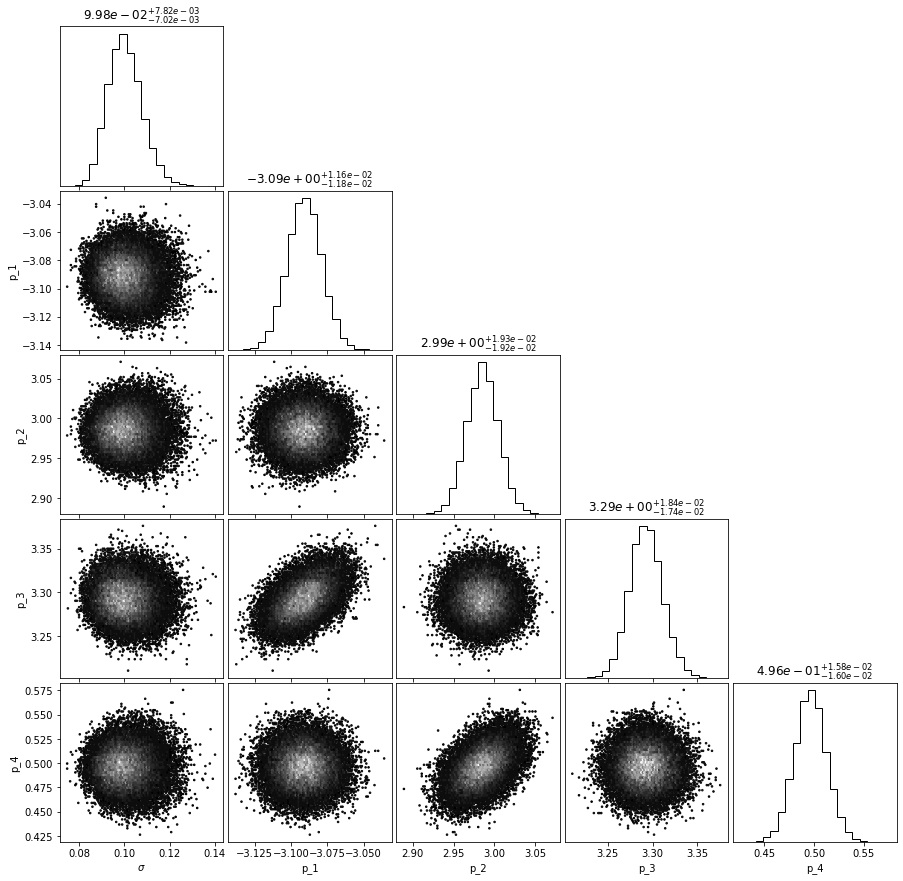

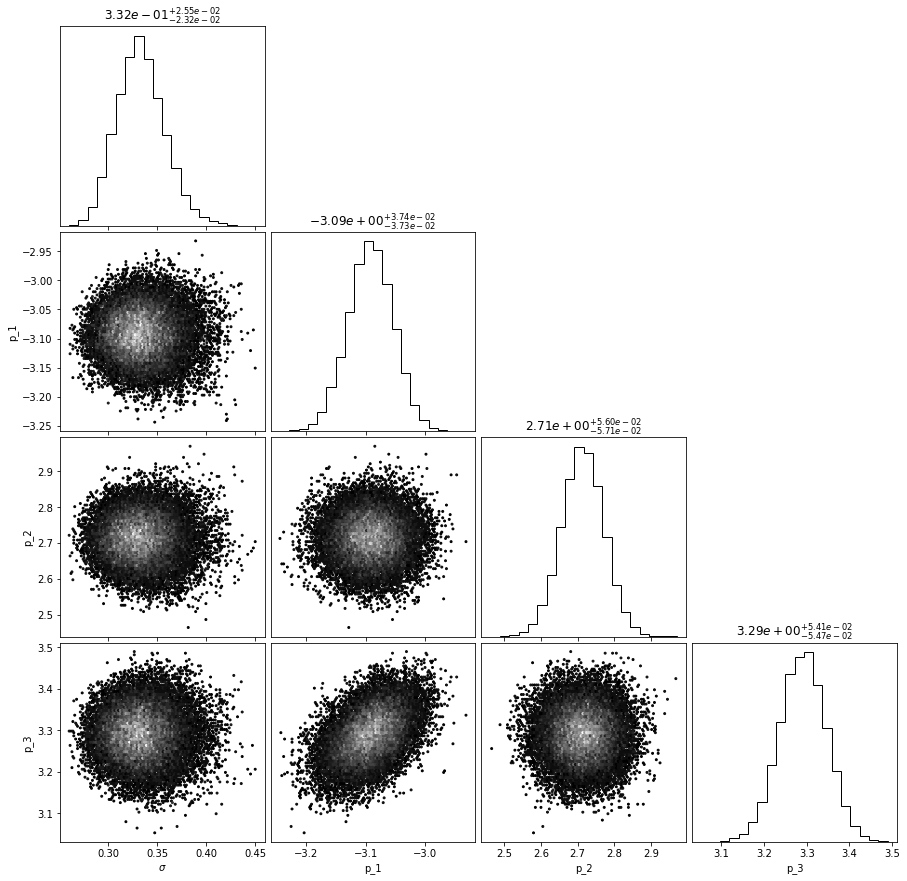

In [25]:
gmcmc.RJcorner(data[0][:,:5],data[1][:,:5],figsize=[15,15],titles = labels,show_quantiles=True)
plt.show()
plt.close()
gmcmc.RJcorner(dataSingle,np.ones(len(dataSingle)*5).reshape((len(dataSingle),5)),figsize=[15,15],titles = labels,show_quantiles=True)
plt.show()
plt.close()

All corners for Bilby

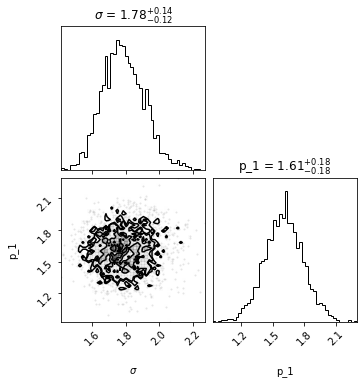

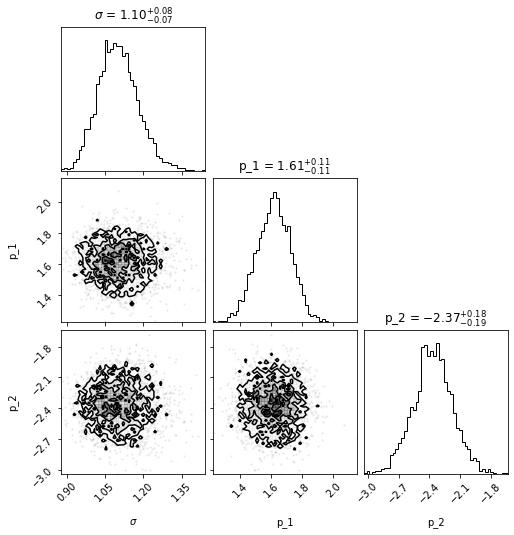

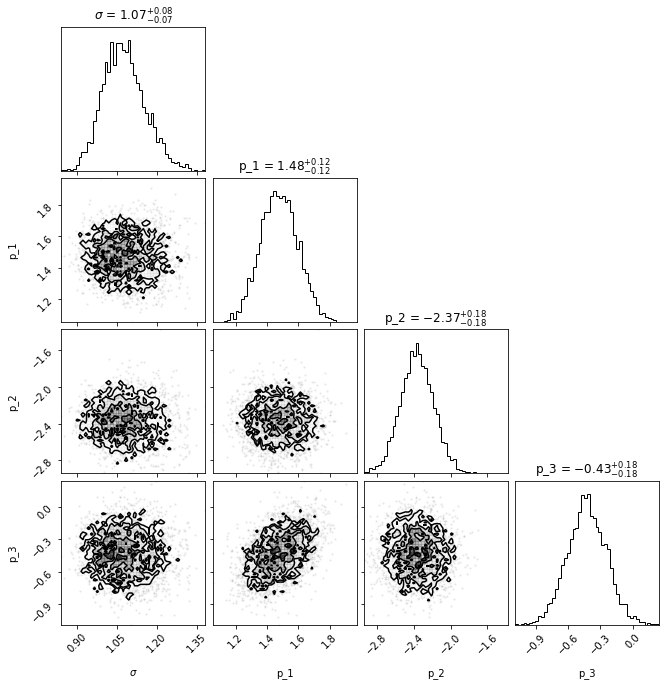

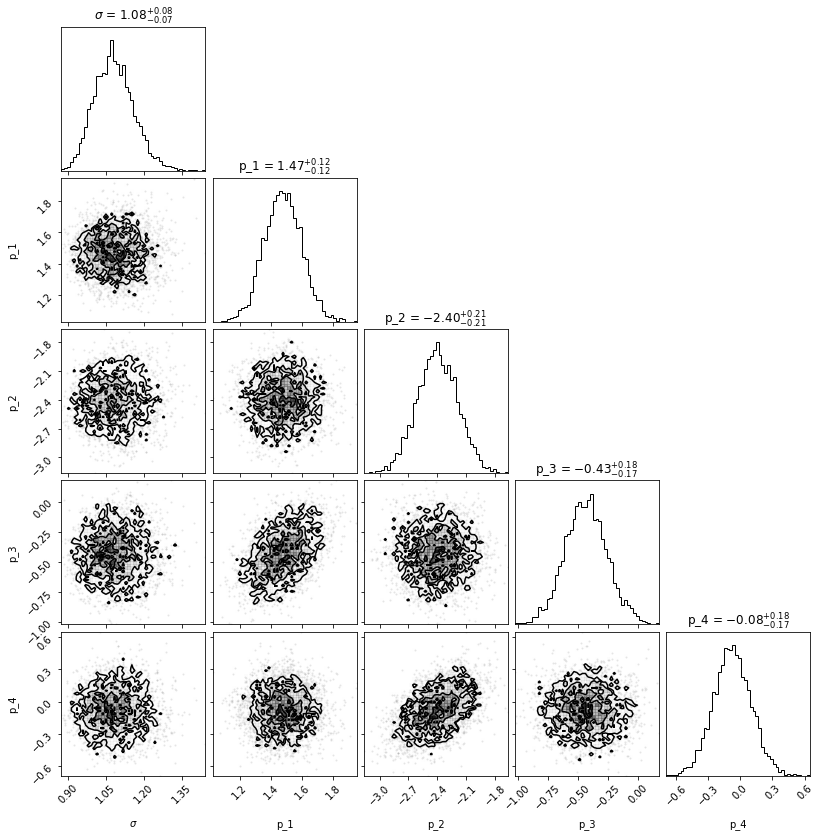

In [31]:

for d in dataBilby:
    corner(d,bins=50,labels=labels,show_titles=True)
   
    plt.show()
    plt.close()

OLD -- GWATPY version with thermodynamic integration

ID = 4
plt.hist(data[0][data[1][:,ID] == 1,ID])

In [17]:
dims = np.sum(data[1],axis=1)

In [27]:
from scipy.integrate import trapz,quad
from scipy.interpolate import interp1d
Ts= [T1,T2,T3,T4]
LLs = [IL1,IL2,IL3,IL4]
lnE = []
for ct in np.arange(len([IL1,IL2,IL3,IL4])):
    
    betas = np.flip(1/Ts[ct][:len(LLs[ct])-1])
    LL = np.flip(LLs[ct][:-1])
    func1 = interp1d(betas,LL,kind='cubic')
    evidence = quad(func1, betas[0],betas[-1])[0]
    evidencetrapz = trapz(LL,x=betas)
    print(evidencetrapz)
    lnE.append(evidence)
print(lnE)
print(evidence1,evidence2,evidence3,evidence4)

-154.94935851038025
-158.36846856845125
-154.80222498957193
-158.2560815146605
[-154.70053591538914, -158.10899946422978, -154.58127558696964, -158.06844451519189]
-151.25118357045355 -141.27632849856428 -152.16412394043797 -158.1436365905243


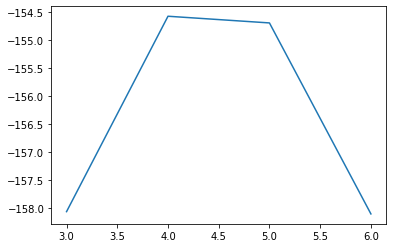

In [28]:
plt.plot(mids[2:6],[lnE[3],lnE[2],lnE[0],lnE[1]])

In [29]:
print("Bayes factor 5/6 (RJ): ",np.sum(dims == 5) / np.sum(dims==6))
print("Bayes factor 5/6 (PTMCMC): ",np.exp(lnE[0] - lnE[1]))
print("Bayes factor 5/4 (RJ): ",np.sum(dims == 5) / np.sum(dims==4))
print("Bayes factor 5/4 (PTMCMC): ",np.exp(lnE[0] - lnE[2]))
print("Bayes factor 5/3 (RJ): ",np.sum(dims == 5) / np.sum(dims==3))
print("Bayes factor 5/3 (PTMCMC): ",np.exp(lnE[0] - lnE[3]))
print("Bayes factor 4/3 (RJ): ",np.sum(dims == 4) / np.sum(dims==3))
print("Bayes factor 4/3 (PTMCMC): ",np.exp(lnE[2] -lnE[3]))

Bayes factor 5/6 (RJ):  612.7832167832167
Bayes factor 5/6 (PTMCMC):  30.218778894792006
Bayes factor 5/4 (RJ):  0.039971846186759405
Bayes factor 5/4 (PTMCMC):  0.887576709241508
Bayes factor 5/3 (RJ):  0.05100044756635069
Bayes factor 5/3 (PTMCMC):  29.017775770343437
Bayes factor 4/3 (RJ):  1.2759092319144492
Bayes factor 4/3 (PTMCMC):  32.69325960022206


[1.00000000e+00 7.23333292e-01 5.26582262e-01 3.88806036e-01
 2.88946099e-01 2.17564663e-01 1.65892221e-01 1.29254587e-01
 1.02645335e-01 8.39887897e-02 7.03391922e-02 5.97632859e-02
 5.06973154e-02 4.15415877e-02 3.17258992e-02 2.08670493e-02
 1.06698879e-02 4.01924911e-03 7.58394366e-04 1.00000000e-08]
[  -137.74968375   -138.81948524   -140.31090172   -142.24167429
   -144.87577336   -148.81580439   -154.10700895   -161.53735263
   -172.16252841   -187.33170947   -207.01972191   -230.25771788
   -256.15961793   -281.4062596    -305.63467382   -329.44510664
   -356.97402936   -402.52921385   -531.44682196 -54956.02076404]


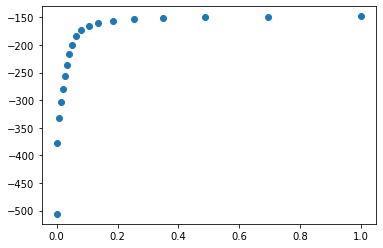

In [19]:
plt.scatter(1/T4[:len(IL4[:-1])],IL4[:-1])
print(1/T1[:len(IL1[:])])
print(IL1)
#plt.plot(IL2[:-1])
#plt.plot(IL3[:-1])
#plt.plot(IL4[:-1])

In [20]:
print(ILNUM1)
print(ILNUM2)
print(ILNUM3)
print(ILNUM4)
print(T1)

[599970 600000 600000 600000 600000 600000 600000 600000 600000 600000
 600000 600000 600000 600000 600000 600000 600000 600000 600000 600000]
[599970 600000 600000 600000 600000 600000 600000 600000 600000 600000
 600000 600000 600000 600000 600000 600000 600000 600000 600000 600000]
[499975 500000 500000 500000 500000 500000 500000 500000 500000 500000
 500000 500000 500000 500000 500000 500000 500000 500000 500000 500000]
[699965 700000 700000 700000 700000 700000 700000 700000 700000 700000
 700000 700000 700000 700000 700000 700000 700000 700000 700000 700000]
[1.00000000e+00 1.38248856e+00 1.89903852e+00 2.57197653e+00
 3.46085309e+00 4.59633465e+00 6.02801019e+00 7.73666935e+00
 9.74228395e+00 1.19063509e+01 1.42168252e+01 1.67326810e+01
 1.97249103e+01 2.40722624e+01 3.15199892e+01 4.79224440e+01
 9.37216973e+01 2.48802692e+02 1.31857520e+03 1.00000000e+08
 1.00000000e+00 1.38248856e+00 1.89903852e+00 2.57197653e+00
 3.46085309e+00 4.59633465e+00 6.02801019e+00 7.73666935e+00
 

0
10
20
30
40
50
60
70
80
90
-137.72707532746116


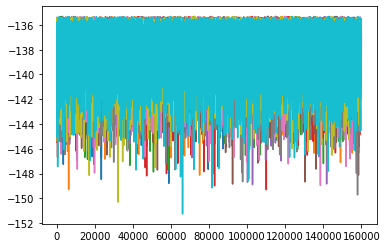

In [36]:
f1 = h5py.File("../data/output_trans_fixed_dim1.hdf5",'r')
LLLP1 = f1["MCMC_OUTPUT"]["LOGL_LOGP"]
num =0
ave = 0
ensemble_member = 9
ensemble_size = 10
for c in LLLP1.keys():
    chain = int(c[5:])
    #if chain%ensemble_size == ensemble_member:
    if True:
        print(chain)
        ave+= np.sum(LLLP1[c][:,0])
        num+=len(LLLP1[c][:,0])
        plt.plot(LLLP1[c][:,0])
print(ave/num)